In [1]:
#Imporing essential libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

from mpl_toolkits.mplot3d import Axes3D

from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('city_temperature.csv')

/home/washieu/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.head(5)

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


In [4]:
df.isnull().sum()

Region                  0
Country                 0
State             1450990
City                    0
Month                   0
Day                     0
Year                    0
AvgTemperature          0
dtype: int64

In [5]:
df.describe().round(1)

,Month,Day,Year,AvgTemperature
count,2906327.0,2906327.0,2906327.0,2906327.0
mean,6.5,15.7,2006.6,56.0
std,3.5,8.8,23.4,32.1
min,1.0,0.0,200.0,-99.0
25%,3.0,8.0,2001.0,45.8
50%,6.0,16.0,2007.0,62.5
75%,9.0,23.0,2013.0,75.5
max,12.0,31.0,2020.0,110.0


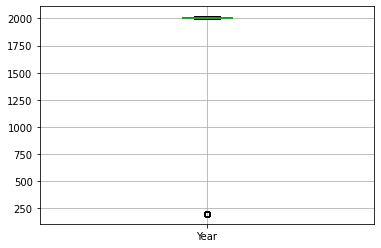

In [6]:
#The 'Year' and 'AvgTemperature' values are wrong. I will visualise this in a boxplot. 
df.boxplot(column='Year')

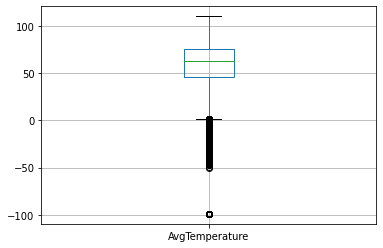

In [7]:
df.boxplot(column='AvgTemperature')

In [8]:
print((df['Year'] == 200).sum())
print((df['AvgTemperature'] == -99).sum())

89
79672


In [9]:
df = df.drop(df[(df.Year == 200) | (df.AvgTemperature == -99)].index)
df = df.drop('State',1)
df.head()

,Region,Country,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,Algiers,1,1,1995,64.2
1,Africa,Algeria,Algiers,1,2,1995,49.4
2,Africa,Algeria,Algiers,1,3,1995,48.8
3,Africa,Algeria,Algiers,1,4,1995,46.4
4,Africa,Algeria,Algiers,1,5,1995,47.9


In [10]:
df.groupby(['Year']).count()[['AvgTemperature']]

,AvgTemperature
Year,
1995,112152
1996,112734
1997,112952
1998,111102
1999,113406
2000,114169
2001,115277
2002,113616
2003,114283


In [11]:
#Now, we can see that we have a pretty nice distribution of data points per year. Now, we have to see if we have good data
#distribution  of data points per city. 



In [12]:
df[(df.Year != 2020)].groupby(['City','Year'])[['AvgTemperature']].count().describe()

,AvgTemperature
count,7680.000000
mean,363.009505
std,65.204843
min,1.000000
25%,363.000000
50%,365.000000
75%,365.000000
max,835.000000


In [13]:
df.groupby('Region').describe()['AvgTemperature']

,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
Africa,220919.0,74.402602,9.272693,33.3,68.6,76.8,81.3,102.8
Asia,306163.0,68.109723,19.722022,-37.2,57.7,75.6,82.7,103.7
Australia/South Pacific,55209.0,62.303693,9.715458,30.7,55.4,62.1,69.4,96.8
Europe,368702.0,51.947171,15.184031,-20.4,41.1,52.6,63.1,102.5
Middle East,120811.0,73.840683,16.798443,3.2,62.8,74.6,87.0,110.0
North America,1548160.0,56.150198,19.320096,-50.0,42.5,58.5,71.8,107.7
South/Central America & Carribean,206691.0,72.202024,10.780375,32.8,66.6,74.8,80.5,97.4


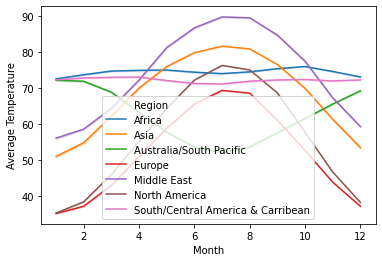

In [14]:
#Because of the greater number of data points for the North American region, our model might have a bias towards North American temperatures. 
#Let's visualise it. 
ax = sns.lineplot(x = 'Month', y = 'AvgTemperature', hue = 'Region', data = df[(df.Year != 2020)])
ax.set(xlabel = 'Month', ylabel='Average Temperature')
plt.show()

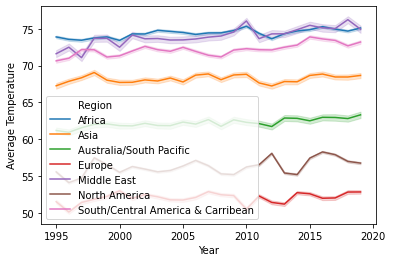

In [15]:
ax = sns.lineplot(x = 'Year', y = 'AvgTemperature', hue = 'Region', data = df[(df.Year != 2020)])
ax.set(xlabel = 'Year', ylabel='Average Temperature')
plt.show()

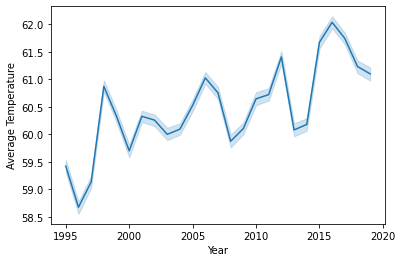

In [16]:
ax = sns.lineplot(x = 'Year', y = 'AvgTemperature', data = df[(df.Year != 2020)])
ax.set(xlabel = 'Year', ylabel='Average Temperature')
plt.show()

In [17]:
#Now, we have to prepare our data for the model. 
#In order to predict the future, I will train the model on the years of 1995-2014. 
#I will validate the model from 2015 to 2019. 
#I will test the model with data on 2020. 
X = df.copy()
y = X.AvgTemperature

X_train = X[(X.Year < 2015)].copy()
X_valid = X[(X.Year > 2014) & (X.Year != 2020)].copy()
X_test = X[(X.Year == 2020)].copy()

y_train = X_train.AvgTemperature
y_valid = X_valid.AvgTemperature
y_test = X_test.AvgTemperature

X_train.drop(['AvgTemperature'], axis=1, inplace=True)
X_valid.drop(['AvgTemperature'], axis=1, inplace=True)
X_test.drop(['AvgTemperature'], axis=1, inplace=True)

In [18]:
print(X_train.Year.unique())
print(X_valid.Year.unique())
print(X_test.Year.unique())

[1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014]
[2015 2016 2017 2018 2019]
[2020]


In [19]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

label_X_train = X_train.copy()
label_X_valid = X_valid.copy()
label_X_test = X_test.copy()

label_encoder = LabelEncoder()
for col in object_cols:
    label_X_train[col] = label_encoder.fit_transform(X_train[col])
    label_X_valid[col] = label_encoder.transform(X_valid[col])
    label_X_test[col] = label_encoder.transform(X_test[col])

In [20]:
label_X_train.head()

,Region,Country,City,Month,Day,Year
0,0,1,7,1,1,1995
1,0,1,7,1,2,1995
2,0,1,7,1,3,1995
3,0,1,7,1,4,1995
4,0,1,7,1,5,1995


In [21]:
#Training and testing our model
model = XGBRegressor(n_estimators=1000,learning_rate=0.05,n_jobs=-1)
model.fit(label_X_train,y_train, early_stopping_rounds=5, eval_set=[(label_X_valid,y_valid)])
predictions = model.predict(label_X_test)
mae = mean_absolute_error(predictions,y_test)
print("Mean Absolute Error:" , mae)

[0]	validation_0-rmse:60.90761
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:58.04028
[2]	validation_0-rmse:55.33026
[3]	validation_0-rmse:52.75720
[4]	validation_0-rmse:50.32101
[5]	validation_0-rmse:48.01041
[6]	validation_0-rmse:45.81779
[7]	validation_0-rmse:43.74538
[8]	validation_0-rmse:41.78392
[9]	validation_0-rmse:39.92568
[10]	validation_0-rmse:38.16533
[11]	validation_0-rmse:36.49858
[12]	validation_0-rmse:34.92609
[13]	validation_0-rmse:33.43530
[14]	validation_0-rmse:32.03000
[15]	validation_0-rmse:30.70193
[16]	validation_0-rmse:29.44800
[17]	validation_0-rmse:28.26596
[18]	validation_0-rmse:27.14996
[19]	validation_0-rmse:26.09219
[20]	validation_0-rmse:25.10442
[21]	validation_0-rmse:24.17560
[22]	validation_0-rmse:23.30081
[23]	validation_0-rmse:22.47729
[24]	validation_0-rmse:21.70173
[25]	validation_0-rmse:20.95285
[26]	validation_0-rmse:20.26916
[27]	validation_0-rmse:19.62010
[28]	validation_0-rmse:19.02117
[29]	validation_0-

[255]	validation_0-rmse:8.07717
[256]	validation_0-rmse:8.06397
[257]	validation_0-rmse:8.05602
[258]	validation_0-rmse:8.04733
[259]	validation_0-rmse:8.04486
[260]	validation_0-rmse:8.04101
[261]	validation_0-rmse:8.03136
[262]	validation_0-rmse:8.03241
[263]	validation_0-rmse:8.02459
[264]	validation_0-rmse:8.01273
[265]	validation_0-rmse:8.00309
[266]	validation_0-rmse:8.00094
[267]	validation_0-rmse:7.99910
[268]	validation_0-rmse:7.99983
[269]	validation_0-rmse:7.99451
[270]	validation_0-rmse:7.98454
[271]	validation_0-rmse:7.97748
[272]	validation_0-rmse:7.97577
[273]	validation_0-rmse:7.97340
[274]	validation_0-rmse:7.97137
[275]	validation_0-rmse:7.96401
[276]	validation_0-rmse:7.95632
[277]	validation_0-rmse:7.94494
[278]	validation_0-rmse:7.94022
[279]	validation_0-rmse:7.93716
[280]	validation_0-rmse:7.92844
[281]	validation_0-rmse:7.92511
[282]	validation_0-rmse:7.92333
[283]	validation_0-rmse:7.92237
[284]	validation_0-rmse:7.91330
[285]	validation_0-rmse:7.90749
[286]	va

[512]	validation_0-rmse:7.29136
[513]	validation_0-rmse:7.29077
[514]	validation_0-rmse:7.28946
[515]	validation_0-rmse:7.28702
[516]	validation_0-rmse:7.28584
[517]	validation_0-rmse:7.28524
[518]	validation_0-rmse:7.28359
[519]	validation_0-rmse:7.28254
[520]	validation_0-rmse:7.28126
[521]	validation_0-rmse:7.28097
[522]	validation_0-rmse:7.28138
[523]	validation_0-rmse:7.28063
[524]	validation_0-rmse:7.27883
[525]	validation_0-rmse:7.27955
[526]	validation_0-rmse:7.27787
[527]	validation_0-rmse:7.27680
[528]	validation_0-rmse:7.27634
[529]	validation_0-rmse:7.27517
[530]	validation_0-rmse:7.27711
[531]	validation_0-rmse:7.27686
[532]	validation_0-rmse:7.27600
[533]	validation_0-rmse:7.27721
[534]	validation_0-rmse:7.27523
Stopping. Best iteration:
[529]	validation_0-rmse:7.27517

Mean Absolute Error: 6.398550455023807


In [22]:
pd.DataFrame(predictions).head()

,0
0,51.609955
1,51.567406
2,51.567406
3,51.567406
4,51.502556


In [23]:
pd.DataFrame(y_test).head()

,AvgTemperature
9132,46.3
9133,45.4
9134,48.0
9135,53.4
9136,47.3
